# QML-RG Homework 5
### Alejandro Pozas-Kerstjens

In [1]:
# Loading libraries, preprocessing images and definig parameters
import os
from keras.preprocessing.image import ImageDataGenerator
from image_loader import load_images
from numpy import loadtxt, floor, argmax, asarray, zeros
import numpy as np
import keras.backend as K

K.set_image_data_format('channels_first')

def preprocess(image):
    im = image.reshape((100,100))
    return np.ndarray.flatten(im)

## Preprocess images: training set
train_images, train_labels = load_images('images/train/')

width = train_images[0].shape[0]
height = train_images[0].shape[1]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
# Some images (baseball, boat, booth and curie) have different shapes than the rest. This is an attempt to fix this
for i in range(len(train_images)):
    if train_images[i].shape != (width, height):
        train_images[i] = train_images[i][:,:,0]

for i in range(len(train_images)):    # Add a third dimension (number of channels) for datagen not to complain
    train_images[i] = train_images[i].reshape((1,) + train_images[i].shape)

for _ in range(8):
    train_images.append(train_images[6])    # Further post-processing: evening-out appearances
    train_images.append(train_images[7])    # of both types of classes, useful for a correct
    train_labels.append(1)                  # data augmentation
    train_labels.append(1)

train_images_flat = []
for i in range(len(train_images)):
    train_images_flat.append(preprocess(train_images[i]))


train_images = asarray(train_images)
train_images_flat = asarray(train_images_flat)
train_labels = asarray(train_labels)

train_images = train_images / 255
train_images_flat = train_images_flat / 255

## Preprocess images: test set
test_images, _ = load_images('images/test/')

for i in range(len(test_images)):
    test_images[i] = test_images[i].reshape((1,) + test_images[i].shape)

test_images_flat = []
for i in range(len(test_images)):
    test_images_flat.append(preprocess(test_images[i]))

test_names = []    # Fancy stuff to feed the output
for file in os.listdir('images/test/'):
    if file.endswith(".png"):
            test_names.append(file)

## Preprocess images: real_world set
rw_images, _ = load_images('images/real_world/')

for i in range(len(rw_images)):    # We just eliminate additional channels and additional rows symmetrically
    if rw_images[i].shape != (rw_images[i].shape[0], rw_images[i].shape[1]):
        rw_images[i] = rw_images[i][:,:,0]
    if rw_images[i].shape != (100, 100):
        offset = int(floor((rw_images[i].shape[1]-100-rw_images[i].shape[1] % 2) / 2))
        rw_images[i] = rw_images[i][:,offset:rw_images[i].shape[1]-offset-(rw_images[i].shape[1] % 2)]

for i in range(len(rw_images)):
    rw_images[i] = rw_images[i].reshape((1,) + rw_images[i].shape)

rw_images_flat = []
for i in range(len(rw_images)):
    rw_images_flat.append(preprocess(rw_images[i]))

rw_images_flat = asarray(rw_images_flat)
rw_names = []    # Fancy stuff to feed the output
for file in os.listdir('images/real_world/'):
    if file.endswith(".png"):
            rw_names.append(file)

Using TensorFlow backend.


## Random Forests

A nice intro to decision trees and random forests can be found in https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

In [2]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=30)    # Create the random forest

In [3]:
# Training with the plain test images

forest.fit(train_images_flat, train_labels)

print(forest.predict(test_images_flat))
rw_pred_labels = forest.predict(rw_images_flat)
rw_real_labels = loadtxt('images/real_world/labels.txt')
tot = 0
eins = 0
for i in range(len(rw_real_labels)):
    if rw_real_labels[i][1] == rw_pred_labels[i] | (rw_real_labels[i][1] == 2 & rw_pred_labels[i] == 1):
        tot += 1
    if ((int(rw_real_labels[i][1]) == 2) | (int(rw_real_labels[i][1]) == 1)) & int(rw_pred_labels[i]) == 1:
        eins += 1
print('Successes in real_world set: {} out of {}'.format(tot,len(rw_real_labels)))
print('Identified correctly {} out of 9 Einsteins and Curies'.format(eins))

[0 0 0 0 0 0]
Successes in real_world set: 58 out of 72
Identified correctly 1 out of 9 Einsteins and Curies


In [4]:
# Training with data augmentation

datagen = ImageDataGenerator(rotation_range=10, shear_range=0.3, zoom_range=0.2,
                             width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant', cval=1)
# Adapting the data augmentation to the forest format
X_train = []
y_train = []
t = 0
nrounds = 50    # Number (times the size of our original training set) of actual training points
for X_batch, y_batch in datagen.flow(train_images, train_labels, batch_size=41 * nrounds):
    for i in range(41):
        X_train.append(preprocess(X_batch[i]))
        y_train.append(y_batch[i])
    t +=1
    if t == nrounds:
        break

X_train = asarray(X_train)
X_train = X_train / 255
y_train = asarray(y_train)

forest.fit(X_train, y_train)

print(forest.predict(test_images_flat))
rw_pred_labels = forest.predict(rw_images_flat)
rw_real_labels = loadtxt('images/real_world/labels.txt')
tot = 0
eins = 0
for i in range(len(rw_real_labels)):
    if rw_real_labels[i][1] == rw_pred_labels[i] | (rw_real_labels[i][1] == 2 & rw_pred_labels[i] == 1):
        tot += 1
    if ((int(rw_real_labels[i][1]) == 2) | (int(rw_real_labels[i][1]) == 1)) & int(rw_pred_labels[i]) == 1:
        eins += 1
print('Successes in real_world set: {} out of {}'.format(tot,len(rw_real_labels)))
print('Identified correctly {} out of 9 Einsteins and Curies'.format(eins))

[0 0 0 0 0 0]
Successes in real_world set: 63 out of 72
Identified correctly 0 out of 9 Einsteins and Curies


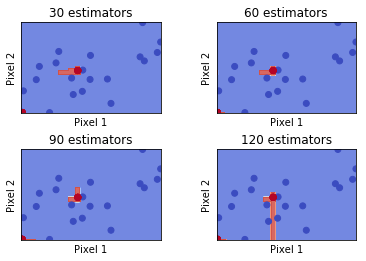

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_estimators = [30, 60, 90, 120]

X = []

for i in range(len(train_images_flat)):
    X.append([train_images_flat[i][3333], train_images_flat[i][6666]])
    
X = asarray(X)

# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))


for i, n_estimators in enumerate(n_estimators):
    forest = RandomForestClassifier(n_estimators=n_estimators)
    
    clf = forest.fit(X, train_labels)
    
    Z = forest.predict(np.c_[xx.ravel(), yy.ravel()])
    
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=train_labels, cmap=plt.cm.coolwarm)
    plt.xlabel('Pixel 1')
    plt.ylabel('Pixel 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title('{} estimators'.format(n_estimators))

plt.show()

## Support Vector Machines

In [6]:
from sklearn import svm

svmachine = svm.SVC(kernel='linear', gamma=1, C=10) 

In [7]:
# Training with unmodified test images

svmachine.fit(train_images_flat, train_labels)

print(svmachine.predict(test_images_flat))
rw_pred_labels = svmachine.predict(rw_images_flat)
rw_real_labels = loadtxt('images/real_world/labels.txt')
tot = 0
eins = 0
for i in range(len(rw_real_labels)):
    if rw_real_labels[i][1] == rw_pred_labels[i] | (rw_real_labels[i][1] == 2 & rw_pred_labels[i] == 1):
        tot += 1
    if ((int(rw_real_labels[i][1]) == 2) | (int(rw_real_labels[i][1]) == 1)) & int(rw_pred_labels[i]) == 1:
        eins += 1
print('Successes in real_world set: {} out of {}'.format(tot,len(rw_real_labels)))
print('Identified correctly {} out of 9 Einsteins and Curies'.format(eins))

[1 0 0 0 0 0]
Successes in real_world set: 51 out of 72
Identified correctly 2 out of 9 Einsteins and Curies


In [8]:
# Training with data augmentation

datagen = ImageDataGenerator(rotation_range=10, shear_range=0.3, zoom_range=0.2,
                             width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant', cval=1)
# Adapting the data augmentation to the svm format
X_train = []
y_train = []
t = 0
nrounds = 50    # Number (times the size of our original training set) of actual training points
for X_batch, y_batch in datagen.flow(train_images, train_labels, batch_size=41 * nrounds):
    for i in range(41):
        X_train.append(preprocess(X_batch[i]))
        y_train.append(y_batch[i])
    t +=1
    if t == nrounds:
        break

X_train = asarray(X_train)
X_train = X_train / 255
y_train = asarray(y_train)

svmachine.fit(X_train, y_train)

print(svmachine.predict(test_images_flat))
rw_pred_labels = svmachine.predict(rw_images_flat)
rw_real_labels = loadtxt('images/real_world/labels.txt')
tot = 0
eins = 0
for i in range(len(rw_real_labels)):
    if rw_real_labels[i][1] == rw_pred_labels[i] | (rw_real_labels[i][1] == 2 & rw_pred_labels[i] == 1):
        tot += 1
    if ((int(rw_real_labels[i][1]) == 2) | (int(rw_real_labels[i][1]) == 1)) & int(rw_pred_labels[i]) == 1:
        eins += 1
print('Successes in real_world set: {} out of {}'.format(tot,len(rw_real_labels)))
print('Identified correctly {} out of 9 Einsteins and Curies'.format(eins))

[0 0 0 0 1 0]
Successes in real_world set: 56 out of 72
Identified correctly 0 out of 9 Einsteins and Curies


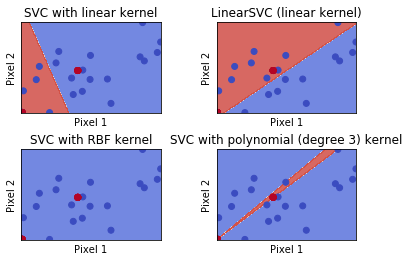

In [9]:
# Example of decision boundary visualization: We train the SVM to identify the images by two pixels

import matplotlib.pyplot as plt

X = []

for i in range(len(train_images_flat)):
    X.append([train_images_flat[i][3333], train_images_flat[i][6666]])
    
X = asarray(X)
    
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, train_labels)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, train_labels)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, train_labels)
lin_svc = svm.LinearSVC(C=C).fit(X, train_labels)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=train_labels, cmap=plt.cm.coolwarm)
    plt.xlabel('Pixel 1')
    plt.ylabel('Pixel 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

As we can see, support vector machines appear to do a better job than random forests in this specific problem, but comparing with the previous homework it looks like nowadays nothing compares to a good deep network